#**Definition of Image Segmentation:**

In **Computer Vision 1.0** what we do is to assign a class to a whole tile (crop) of images. In **Computer Vision 2.0** we assign a class to each pixel of the image.  

**Segmentation:** It is the process of partitioning (segment) a digital image into multiple parts or segments (sets of pixels). 



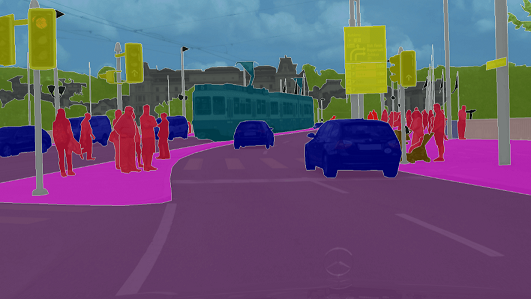

Traditionally, researches have designed some algorithms in order to address this task, such as the Watershed algorithm, **Image thresholding**, K-means clustering, Graph partitioning methods, etc. The simplest method would be the thresholding method. In this method a gray-scale image is converted into a binary image based on a threshold value. In spite of many traditional image processing techniques, however **Deep Learning** has changed the games with very cutting-edge breakthroughs.

We can split **Computer Vision** tasks into 4 types: 

1) **Classification:** consisting in making a prediction for a whole input, i.e., predicting the object in an image. 

2) **Localization:** The next step towards fine-grained inference is localization or detection, providing not only the classes but also additional information regarding the spatial location of those classes. In this case the model will yield the class and the bounding-box of the objects detected and localized within the scene of the image. In general, bounding-box is synonim of Localization task. 

3) **Semantic segmentation:** it is a pixel-oriented classification, which can be seen as a dense-prediction task. In dense prediction, the objective is to generate an output map of the same size as that of the input image. Now, it is obvious that semantic segmentation is the natural step to achieve fine-grained inference. Its goal is to make dense predictions inferring labels for every pixel. This way, each pixel is labeled with the class of its enclosing object or region. 

4) **Instance Segmentation:** It is an  improvement of Semantic Segmentation where we have separate labels for different instances of the same class. Instance segmentation is one step ahead of semantic segmentation wherein along with pixel level classification, we expect the computer to classify each instance of a class separately. Semantic segmentation does not differentiate between the instances of a particular class. This is useful for example in cars segmentation for traffic control, with instance segmentation we could distinguish amongst all the different types of cars. 

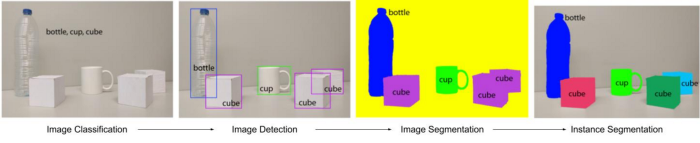

#**Applications of Segmentation**

**1) Autonomous Vehicles, Drones and Robots:** Semantic Segmentation provides information about free space on the roads, as well as to detect lane markings and traffic signs, so it is precise as needed for self-driving vehicles. 

**2) Bio-medics:** Machines can augment analysis performed by radiologists, greatly reducing the time required to run diagnostic tests. Segmentation can take significant parts from ct-scans, for instance, and increase the power of classification models. 

**3) Satellite Imagery:** Land cover information is important for monitoring areas of deforestation and urbanization or for Official Statistics purposes. To recognize the type of land cover (e.g., areas of urban, agriculture, water, etc.) for each pixel on a satellite image, land cover classification can be regarded as a multi-class semantic segmentation task. Road and building detection is also an important research topic for traffic management, city planning, and road monitoring.

**4) Precision Agriculture:** Precision farming robots can reduce the amount of herbicides that need to be sprayed out in the fields and semantic segmentation of crops and weeds assist them in real time to trigger weeding actions. Such advanced image vision techniques for agriculture can reduce manual monitoring of agriculture.

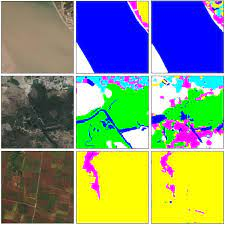

#**UNET**

UNet is a **Convolutionary Autoencoder** that is born for BioMedical Image segmentation [1]. The introduced architecture had two main parts that were encoder and decoder. The encoder is all about the conv layers followed by pooling operation. It is used to extract the factors in the image. The second part decoder uses transposed convolution to permit localization. It is again an F.C connected layers network. You can read the original published paper U-Net: Convolutional Networks for Biomedical Image Segmentation. Also, read more about UNet architecture that is published with the name as Understanding Semantic Segmentation with UNet.

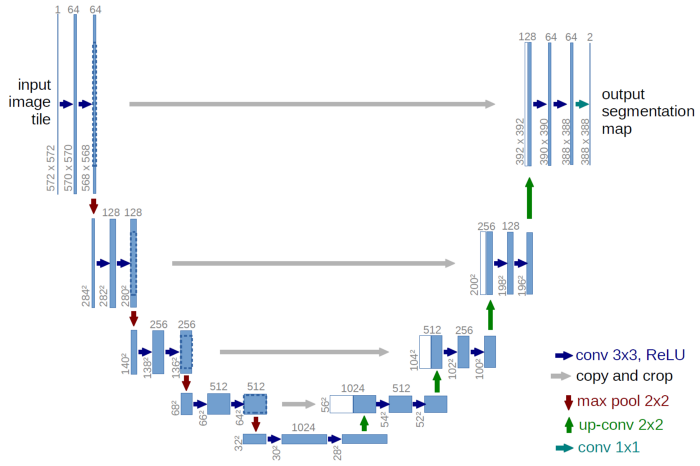

#**What are PIL Images?**

**Python Imaging Library (PIL)** is a free and open-source additional library for the Python programming language that adds support for opening, manipulating, and saving many different image file formats. Development of the original project, known as PIL, was discontinued in 2011. Subsequently, a successor project named Pillow forked the **PIL** repository and added Python 3.x support.

Pillow offers several standard procedures for image manipulation. These include:

1) per-pixel manipulations,
2) masking and transparency handling,
3) image filtering, such as blurring, contouring, smoothing, or edge finding,
4) image enhancing, such as sharpening, adjusting brightness, contrast or color,
5) adding text to images and much more.

Some of the file formats supported are **PPM, PNG, JPEG, GIF, TIFF,** and **BMP**. It is also possible to create new file decoders to expand the library of file formats accessible.

#**All Imports**

In [1]:
import os
import glob
import cv2
import pdb
import timeit
import platform 
import numpy as np
from matplotlib import pyplot as plt
import random 
from skimage.io import imshow
from PIL import Image
import pandas as pd
#import segmentation_models as sm

#**All Keras Imports**

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

#**All Scikit-Learn Imports**

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

#**All Globals**

In [4]:
small_dataset = True
verbose = True
limit = 40
epochs = 100
batch_size = 32

if small_dataset is True: 
  images_path = "/content/semantic_drone_dataset_small/training_set/images/*.jpg"
  masks_path = "/content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/*.png"
  classes_path = "/content/semantic_drone_dataset_small/training_set/gt/semantic/class_dict.csv"
else: 
  images_path = "/content/semantic_drone_dataset/training_set/images/*.jpg"
  masks_path = "/content/semantic_drone_dataset/training_set/gt/semantic/label_images/*.png"
  classes_path = "/content/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv"

#**All Models Functions Definitions**

In [6]:
def unet(n_classes=2, height=256, width=256, channels=3):
    inputs = Input((height, width, channels))

    #Contraction path
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv_1 = Dropout(0.1)(conv_1)  
    conv_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)
    pool_1 = MaxPooling2D((2, 2))(conv_1)
    
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_1)
    conv_2 = Dropout(0.1)(conv_2)  
    conv_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)
    pool_2 = MaxPooling2D((2, 2))(conv_2)
     
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_2)
    conv_3 = Dropout(0.1)(conv_3)
    conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)
    pool_3 = MaxPooling2D((2, 2))(conv_3)
     
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_3)
    conv_4 = Dropout(0.1)(conv_4)
    conv_4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
     
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool_4)
    conv_5 = Dropout(0.2)(conv_5)
    conv_5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    u6 = concatenate([u6, conv_4])
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    conv_6 = Dropout(0.2)(conv_6)
    conv_6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    u7 = concatenate([u7, conv_3])
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    conv_7 = Dropout(0.1)(conv_7)
    conv_7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    u8 = concatenate([u8, conv_2])
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    conv_8 = Dropout(0.2)(conv_8)  
    conv_8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    u9 = concatenate([u9, conv_1], axis=3)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    conv_9 = Dropout(0.1)(conv_9)
    conv_9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

#**All Functions Definitions**

In [7]:
def jacard(y_true, y_pred):
    y_true_c = K.flatten(y_true)
    y_pred_c = K.flatten(y_pred)
    intersection = K.sum(y_true_c * y_pred_c)
    return (intersection + 1.0) / (K.sum(y_true_c) + K.sum(y_pred_c) - intersection + 1.0) 

def jacard_loss(y_true, y_pred):
    return -jacard(y_true,y_pred)

def read_images(path, limit):
    images = []
    i = 0
    for filename in sorted(glob.glob(path)):
        if verbose is True: 
          print("Loading Image: ", filename)
        img = Image.open(filename,'r')
        img = img.resize((256,256))
        img = np.array(img)
        images.append(img)  
        if limit is not None: 
          if i>limit: 
            break
          else: 
            i+=1 
    return images

def read_masks(target, targets_classes_colors):
    image_classes = np.zeros(target.shape, dtype=np.uint8)
    for i in range(24):
        image_classes[np.all(target == targets_classes_colors[i,:], axis=-1)] = i # np.all: Tests whether all array elements along a given axis evaluate to True.
    image_classes = image_classes[:,:,0]
    return image_classes
    
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

#**All Downloads**

In [8]:
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

if small_dataset is True: 
  out = data_download("./semantic_drone_dataset_small.zip", "1Yk_zkP591KUu0mcEamvBbYedhkq52Pdt", OS)
else: 
  out = data_download("./drone_dataset.zip", "1sIBIuffv1HD9als94zvhCZevJyi2ewzd", OS)

print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  12.561550861000114


#**Import of Training Set Images and Masks**

**Note!** An 'r' before a string tells the Python interpreter to treat backslashes as a literal (raw) character. Normally, Python uses backslashes as escape characters.

**importing_data**: Reads all Images with PIL and resizes them to 256x256 which is the default input sizes for the Unet. 

In [9]:
dataset_x = np.asarray(read_images(images_path, limit))

Loading Image:  /content/semantic_drone_dataset_small/training_set/images/000.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/001.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/002.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/003.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/004.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/005.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/006.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/008.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/011.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/013.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/014.jpg
Loading Image:  /content/semantic_drone_dataset_small/training_set/images/015.jpg
Loading Image:  

In [10]:
dataset_y_masks = np.asarray(read_images(masks_path, limit))

Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/000.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/001.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/002.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/003.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/004.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/005.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/006.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/008.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/011.png
Loading Image:  /content/semantic_drone_dataset_small/training_set/gt/semantic/label_images/013.png


#**All Dataset Shapes and Inspection**

In [11]:
print("Dataset Images Shape: ", dataset_x.shape)
print("Masks Shape: ", dataset_y_masks.shape)
if verbose is True: 
  print("Some elements of Dataset Images:\n",dataset_x[0:1,:,:,:])
  print("Some elements of Dataset Masks (Target):\n",dataset_y_masks[0:1,:,:,:])

Dataset Images Shape:  (21, 256, 256, 3)
Masks Shape:  (21, 256, 256, 3)
Some elements of Dataset Images:
 [[[[107 114  32]
   [124 127  40]
   [127 132  38]
   ...
   [ 85  89  98]
   [ 24  30  45]
   [ 23  28  41]]

  [[ 89 102  32]
   [114 116  39]
   [ 93  96  29]
   ...
   [ 36  39  52]
   [ 21  26  40]
   [ 23  25  39]]

  [[ 92 102  36]
   [110 116  35]
   [109 118  32]
   ...
   [ 22  26  40]
   [ 23  26  39]
   [ 22  24  36]]

  ...

  [[113 121 127]
   [117 124 131]
   [119 126 132]
   ...
   [107 112 117]
   [114 118 121]
   [105 108 113]]

  [[113 122 128]
   [114 123 128]
   [115 120 127]
   ...
   [105 112 117]
   [105 112 117]
   [101 108 115]]

  [[116 124 128]
   [120 129 134]
   [119 127 132]
   ...
   [109 116 121]
   [111 118 123]
   [110 115 119]]]]
Some elements of Dataset Masks (Target):
 [[[[ 97 129  32]
   [108 143  35]
   [106 141  35]
   ...
   [123  61 123]
   [123  61 123]
   [123  61 123]]

  [[ 97 129  32]
   [108 143  35]
   [107 142  35]
   ...
   [129 

#**Sanity Check: Visualization**

**Note:** Re-execute in order to see another pair image-mask

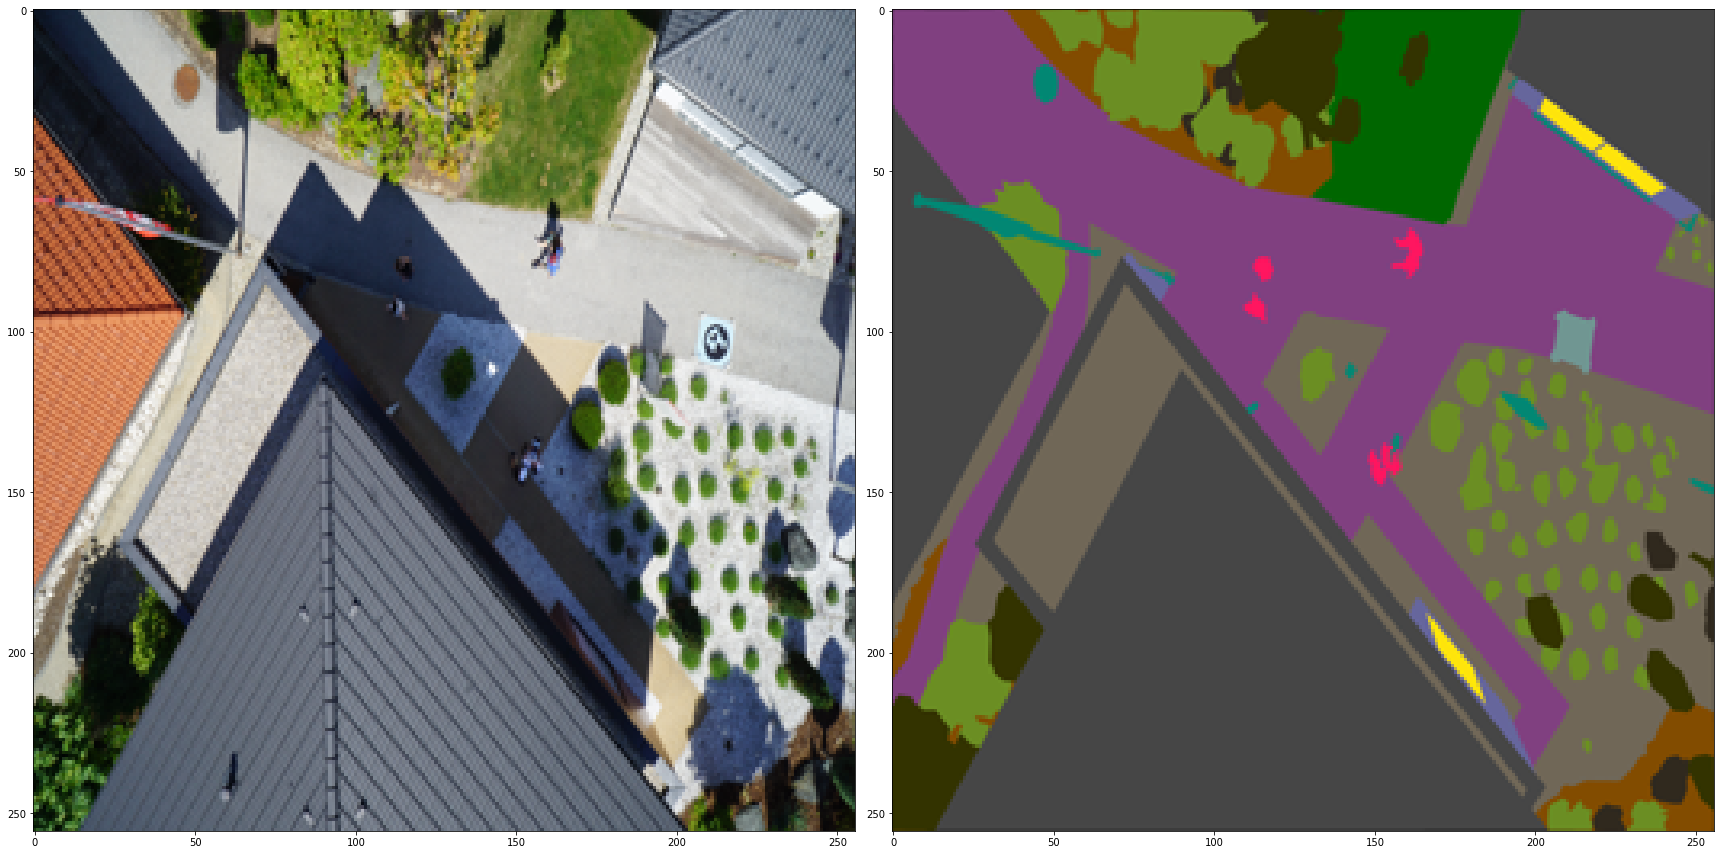

In [16]:
x = random.randint(0, len(dataset_x))
plt.figure(figsize=(24,18))
plt.subplot(1,2,1)
imshow(dataset_x[x])
plt.subplot(1,2,2)
imshow(dataset_y_masks[x])
plt.show()

#**Input Images Normalization**

**Very Important:** MinMaxScaler expects a number of dim <= 2, so we need to flatten data before normalize with MinMaxScaler and then we de-flatten data. 

In [19]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
nsamples, nx, ny, nz = dataset_x.shape
train_images_flatten = dataset_x.reshape((nsamples,nx*ny*nz))
train_images = scaler.fit_transform(train_images_flatten)
train_images = train_images.reshape(nsamples,256,256,3)

In [20]:
print("Dataset Images Shape: ", train_images.shape)
if verbose is True: 
  print("Some elements of Dataset Images:\n",train_images[0:1,:,:,:])

Dataset Images Shape:  (21, 256, 256, 3)
Some elements of Dataset Images:
 [[[[0.7890625  0.88333333 0.232     ]
   [0.59296482 0.625      0.16814159]
   [0.50612245 0.5        0.14741036]
   ...
   [0.4        0.40314136 0.47668394]
   [0.08284024 0.10227273 0.21910112]
   [0.07647059 0.1011236  0.19444444]]

  [[0.61029412 0.7768595  0.23387097]
   [0.49541284 0.49537037 0.15416667]
   [0.37142857 0.3699187  0.10843373]
   ...
   [0.1396648  0.15300546 0.25414365]
   [0.05454545 0.07514451 0.18390805]
   [0.0867052  0.09444444 0.18539326]]

  [[0.70491803 0.76229508 0.25      ]
   [0.44396552 0.45258621 0.13654618]
   [0.43852459 0.46122449 0.12096774]
   ...
   [0.06470588 0.07471264 0.1875    ]
   [0.07821229 0.08743169 0.18232044]
   [0.02380952 0.0295858  0.13772455]]

  ...

  [[0.57978723 0.66863905 0.68390805]
   [0.73548387 0.74358974 0.76923077]
   [0.72222222 0.75903614 0.76162791]
   ...
   [0.45982143 0.51173709 0.76821192]
   [0.52112676 0.58163265 0.83333333]
   [0.6158

#**Labels of the masks**

In [21]:
targets_classes_colors = pd.read_csv(classes_path)
targets_classes_colors = np.array(targets_classes_colors.drop(['name'], axis = 1))

In [22]:
if verbose is True: 
  print("Targets Shape: ", targets_classes_colors.shape)  
  print("Targets Classes Colours Combinations: ", targets_classes_colors)

Targets Shape:  (24, 3)
Targets Classes Colours Combinations:  [[  0   0   0]
 [128  64 128]
 [130  76   0]
 [  0 102   0]
 [112 103  87]
 [ 28  42 168]
 [ 48  41  30]
 [  0  50  89]
 [107 142  35]
 [ 70  70  70]
 [102 102 156]
 [254 228  12]
 [254 148  12]
 [190 153 153]
 [153 153 153]
 [255  22  96]
 [102  51   0]
 [  9 143 150]
 [119  11  32]
 [ 51  51   0]
 [190 250 190]
 [112 150 146]
 [  2 135 115]
 [255   0   0]]


#**Loading Segmentation Masks into a unique Structure**

In [23]:
target_final = []
for i in range(dataset_y_masks.shape[0]):
    target = read_masks(dataset_y_masks[i], targets_classes_colors)
    target_final.append(target)    

target_final = np.array(target_final)  

In [24]:
if verbose is True: 
  print("Shape of Targets: ", target_final.shape)
  print("First Elements of Targets: ", target_final[0])

Shape of Targets:  (21, 256, 256)
First Elements of Targets:  [[0 0 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 [0 0 8 ... 1 1 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [26]:
target_final[0,0:20,0:20]

array([[0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 8, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 8, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 8, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [0, 0, 8, 8, 0, 0, 0, 0, 4,

#**Targets One-Hot Encoding**

In [27]:
n_classes = len(np.unique(target_final))
onehot_targets = to_categorical(target_final, num_classes = n_classes)

In [28]:
if verbose is True: 
  print("Shape of Targets One-Hot Encoding: ", onehot_targets.shape)
  print("First Elements ff Targets One-Hot Encoding: ", onehot_targets[0])

Shape of Targets One-Hot Encoding:  (21, 256, 256, 23)
First Elements ff Targets One-Hot Encoding:  [[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 

#**Train-Val-Test Split**

In [29]:
x_train, x_val, y_train, y_val = train_test_split(train_images, onehot_targets, test_size = 0.10, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.10, random_state = 42)

In [30]:
if verbose is True: 
  print("X Train Shape: ", x_train.shape)
  print("Y Train Shape: ", y_train.shape)
  print("X Val Shape: ", x_val.shape)
  print("Y Val Shape: ", y_val.shape)
  print("X Test Shape: ", x_test.shape)
  print("Y Test Shape: ", y_test.shape)

X Train Shape:  (16, 256, 256, 3)
Y Train Shape:  (16, 256, 256, 23)
X Val Shape:  (3, 256, 256, 3)
Y Val Shape:  (3, 256, 256, 23)
X Test Shape:  (2, 256, 256, 3)
Y Test Shape:  (2, 256, 256, 23)


#**Model Definition**

In [31]:
height = x_train.shape[1]
width  = x_train.shape[2]
n_channels = x_train.shape[3]

metrics=['accuracy', jacard]

model = unet(n_classes=n_classes, height = height, width = width, channels = n_channels)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
if verbose is True: 
  model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

#**Model Training**

In [33]:
history = model.fit(x_train, y_train, batch_size = batch_size, verbose=1, epochs=epochs, validation_data=(x_val, y_val), shuffle=False)

Epoch 1/100
1/1 [==============================] - 19s 19s/step - loss: 3.3827 - accuracy: 0.0983 - jacard: 0.0213 - val_loss: 3.2465 - val_accuracy: 0.1017 - val_jacard: 0.0215
Epoch 2/100
1/1 [==============================] - 0s 464ms/step - loss: 3.2259 - accuracy: 0.0749 - jacard: 0.0221 - val_loss: 3.1372 - val_accuracy: 0.1960 - val_jacard: 0.0230
Epoch 3/100
1/1 [==============================] - 0s 478ms/step - loss: 3.1381 - accuracy: 0.0821 - jacard: 0.0230 - val_loss: 3.0740 - val_accuracy: 0.1014 - val_jacard: 0.0244
Epoch 4/100
1/1 [==============================] - 0s 472ms/step - loss: 3.0712 - accuracy: 0.0736 - jacard: 0.0256 - val_loss: 3.0312 - val_accuracy: 0.1260 - val_jacard: 0.0256
Epoch 5/100
1/1 [==============================] - 0s 475ms/step - loss: 3.0109 - accuracy: 0.0923 - jacard: 0.0276 - val_loss: 2.9352 - val_accuracy: 0.1214 - val_jacard: 0.0308
Epoch 6/100
1/1 [==============================] - 0s 457ms/step - loss: 2.9763 - accuracy: 0.1089 - jacar

#**Loss, Accuracy and Jacard Distance Visualization**

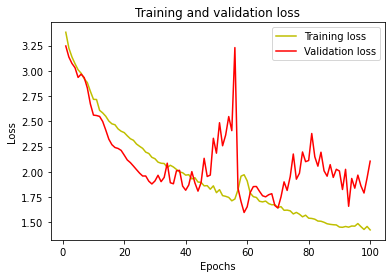

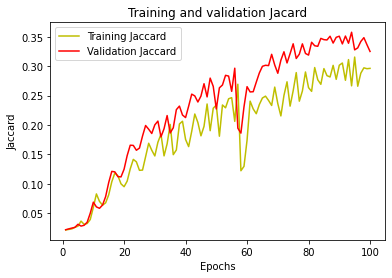

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard']
val_acc = history.history['val_jacard']

plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()


#**Model Prediction Sanity Check**

In [35]:
y_pred = model.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

test_jacard = jacard(y_test, y_pred)
print(test_jacard)

tf.Tensor(0.37629792, shape=(), dtype=float32)


In [ ]:
x_test.shape

#**Predictions Visualization**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
2


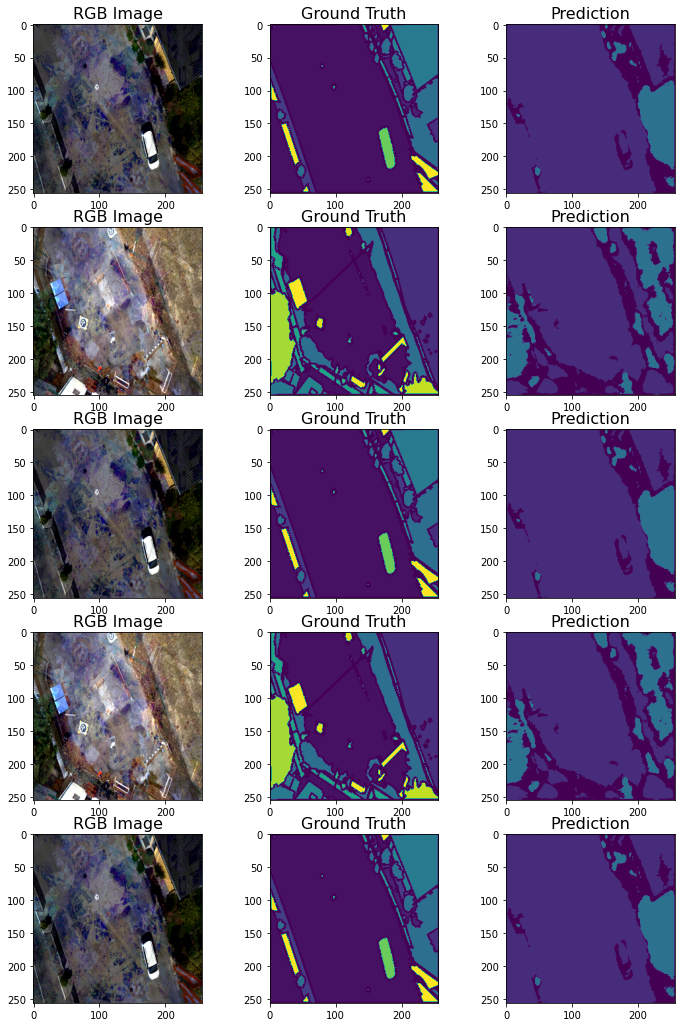

In [39]:
fig, ax = plt.subplots(5, 3, figsize = (12,18)) 
for i in range(0,5):
    test_img_number = random.randint(0, len(x_test))
    print(test_img_number)
    test_img = x_test[test_img_number-1]
    ground_truth=y_test_argmax[test_img_number-1] 
    test_img_input=np.expand_dims(test_img, 0) 
    prediction = (model.predict(test_img_input)) 
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]    
    
    ax[i,0].imshow(test_img)
    ax[i,0].set_title("RGB Image",fontsize=16)
    ax[i,1].imshow(ground_truth)
    ax[i,1].set_title("Ground Truth",fontsize=16)
    ax[i,2].imshow(predicted_img)
    ax[i,2].set_title("Prediction",fontsize=16)
    i+=i
    
plt.show()

# **Reference**

Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

https://deepsense.ai/deep-learning-for-satellite-imagery-via-image-segmentation/


#**Homeworks**

1) Run the Model on the Entire Big Dataset

2) Add all the standard callbacks: Model Checkpoint (Savebestmodel), EarlyStopping, ReduceLROnPlateau, etc. 

2) Visualize some internals of Contrancting Part's Conv Layers behaviours with the known techniques: Filters Visualization and Feature Maps Visualization